In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="True"

In [2]:
def process_FAA_hourly_data(filename):
    path = os.getcwd()
    pathfile = os.path.join(path,"data",filename)
    df_temps = pd.read_csv(pathfile, skiprows=16)
    df_temps = df_temps.iloc[:,:-1]
    df_temps = df_temps.loc[df_temps[df_temps.columns[0]] != df_temps.columns[0]]
    df_temps[df_temps.columns[1]] = df_temps[df_temps.columns[1]].apply(pd.to_numeric, downcast = "integer")
    df_temps[df_temps.columns[2:]] = df_temps[df_temps.columns[2:]].apply(pd.to_numeric, downcast = "float")
    df_temps = df_temps.set_index(pd.DatetimeIndex(df_temps[df_temps.columns[0]]))
    df_temps = df_temps.drop([df_temps.columns[0]], axis=1)
    return df_temps

In [3]:
df_kphl = process_FAA_hourly_data("faa_hourly-KPHL_20120101-20190101.csv")


In [4]:
df_kphl_useful = df_kphl.iloc[:,[1,7,8,9]]
df_kphl_temp = df_kphl.iloc[:,1]

In [5]:
#df_kphl_useful contains four different variables
start = df_kphl_useful.index[0]
end = df_kphl_useful.index[-1]
idx = pd.date_range(start, end, freq='H')

df_kphl_useful = df_kphl_useful.reindex(idx, fill_value = np.nan)


In [6]:
#df_kphl_temp contains only temperature data
start = df_kphl_temp.index[0]
end = df_kphl_temp.index[-1]
idx = pd.date_range(start, end, freq='H')

df_kphl_temp = df_kphl_temp.reindex(idx, fill_value = np.nan)


In [7]:
print("Start day four variables is {}".format(df_kphl_useful.index[0]))
print("End day four variables is {}".format(df_kphl_useful.index[-1]))
print("\n\n")
print("Start day for temperature is {}".format(df_kphl_useful.index[0]))
print("End day for temperature is {}".format(df_kphl_useful.index[-1]))

Start day four variables is 2012-01-01 00:00:00
End day four variables is 2019-01-01 23:00:00



Start day for temperature is 2012-01-01 00:00:00
End day for temperature is 2019-01-01 23:00:00


In [8]:
temp = np.array(df_kphl_temp)
temp = temp.reshape(-1,1)

In [9]:
#Stacked auto encoder
from keras.layers import *
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, RepeatVector

Using TensorFlow backend.


In [10]:
# split into train and test sets (67% of them are for train data)

temp = np.nan_to_num(temp)
train, test = temp[0:(1713*30),:], temp[(1713*30):len(temp),:]
print(len(train), len(test))


51390 10002


In [11]:
#Get Only temperature data
def create_datasettemp(dataset, look_back=25):
    data = []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0].flatten()
        data.append(a)
    return np.array(data)

#Get all four variables
def create_dataset(dataset, look_back=24):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :].flatten()
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
# reshape into X=t and Y=t+1
look_back = 25
traindata = create_datasettemp(train, look_back)
testdata = create_datasettemp(test, look_back)


traindata.shape


(51364, 25)

In [13]:
trainX = traindata[:,0:-1]
trainY = traindata[:,-1]

testX = testdata[:,0:-1]
testY = testdata[:,-1]

In [14]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(51364, 1, 24) (9976, 1, 24) (51364,) (9976,)


In [15]:
#This is for temperature 
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(trainX, trainY, epochs=50, batch_size=72, validation_data=(testX, testY), verbose=2, shuffle=False)

Train on 51364 samples, validate on 9976 samples
Epoch 1/50
 - 10s - loss: 48.3483 - val_loss: 36.6078
Epoch 2/50
 - 6s - loss: 32.0421 - val_loss: 22.0945
Epoch 3/50
 - 8s - loss: 20.7767 - val_loss: 16.6399
Epoch 4/50
 - 12s - loss: 21.1133 - val_loss: 17.6813
Epoch 5/50
 - 7s - loss: 19.9706 - val_loss: 17.0785
Epoch 6/50
 - 7s - loss: 18.6675 - val_loss: 16.4342
Epoch 7/50
 - 6s - loss: 19.6613 - val_loss: 16.7345
Epoch 8/50
 - 5s - loss: 17.9522 - val_loss: 16.3411
Epoch 9/50
 - 6s - loss: 16.6822 - val_loss: 16.2381
Epoch 10/50
 - 7s - loss: 16.0891 - val_loss: 16.3868
Epoch 11/50
 - 7s - loss: 16.7944 - val_loss: 16.2347
Epoch 12/50
 - 6s - loss: 16.3841 - val_loss: 16.3732
Epoch 13/50
 - 5s - loss: 16.7633 - val_loss: 16.2361
Epoch 14/50
 - 6s - loss: 16.1065 - val_loss: 16.3776
Epoch 15/50
 - 6s - loss: 15.9221 - val_loss: 16.5032
Epoch 16/50
 - 6s - loss: 15.8011 - val_loss: 16.6423
Epoch 17/50
 - 6s - loss: 15.7623 - val_loss: 16.7403
Epoch 18/50
 - 6s - loss: 15.7517 - val_

In [19]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)



(51364,)

In [24]:
print(testY.shape)
print(trainPredict.shape)
trainPredict[:,0].shape

(9976,)
(51364, 1)


(51364,)

In [25]:
# calculate root mean squared error
import math
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score for only temp: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score for only temp: %.2f RMSE' % (testScore))


Train Score for only temp: 18.68 RMSE
Test Score for only temp: 19.70 RMSE


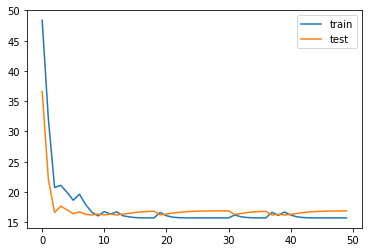

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend() 
plt.show()

In [28]:
# split into train and test sets (67% of them are for train data)
useful = np.array(df_kphl_useful)

useful = np.nan_to_num(useful)
train, test = useful[0:(1713*30),:], useful[(1713*30):len(useful),:]
print(len(train), len(test))


51390 10002


In [29]:
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [30]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(51365, 1, 96) (9977, 1, 96) (51365,) (9977,)


In [31]:
#This is for all data 
model = Sequential()
model.add(LSTM(96, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(trainX, trainY, epochs=60, batch_size=72, validation_data=(testX, testY), verbose=2, shuffle=False)

Train on 51365 samples, validate on 9977 samples
Epoch 1/60
 - 17s - loss: 41.0760 - val_loss: 24.9369
Epoch 2/60
 - 11s - loss: 21.1826 - val_loss: 16.4118
Epoch 3/60
 - 11s - loss: 16.5340 - val_loss: 16.3966
Epoch 4/60
 - 10s - loss: 15.9131 - val_loss: 16.7411
Epoch 5/60
 - 9s - loss: 15.8508 - val_loss: 16.9116
Epoch 6/60
 - 9s - loss: 15.8538 - val_loss: 16.9701
Epoch 7/60
 - 9s - loss: 15.8573 - val_loss: 16.9981
Epoch 8/60
 - 9s - loss: 15.8608 - val_loss: 17.0072
Epoch 9/60
 - 9s - loss: 15.8619 - val_loss: 17.0091
Epoch 10/60
 - 9s - loss: 15.8624 - val_loss: 17.0085
Epoch 11/60
 - 9s - loss: 15.8624 - val_loss: 17.0084
Epoch 12/60
 - 9s - loss: 15.8621 - val_loss: 17.0083
Epoch 13/60
 - 9s - loss: 15.8627 - val_loss: 17.0086
Epoch 14/60
 - 9s - loss: 15.8621 - val_loss: 17.0088
Epoch 15/60
 - 9s - loss: 15.8622 - val_loss: 17.0078
Epoch 16/60
 - 9s - loss: 15.8621 - val_loss: 17.0076
Epoch 17/60
 - 9s - loss: 15.8618 - val_loss: 17.0084
Epoch 18/60
 - 9s - loss: 15.8621 - va

In [36]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [37]:
# calculate root mean squared error
import math
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score for only temp: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score for only temp: %.2f RMSE' % (testScore))


Train Score for only temp: 18.73 RMSE
Test Score for only temp: 19.83 RMSE
